Generating 3x3, 1+8+1 supremacy circuit


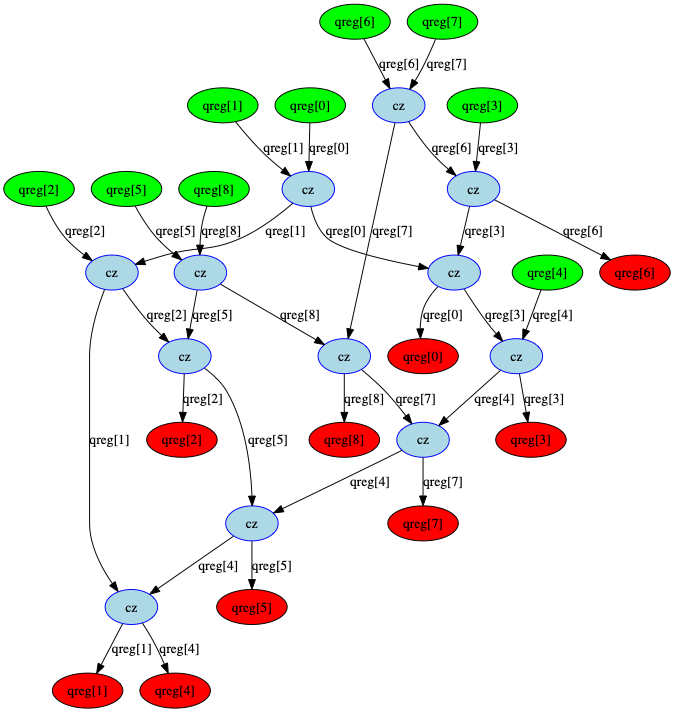

In [2]:
from randomized_searcher import *
from qcg.generators import gen_supremacy
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.tools.visualization import dag_drawer
import randomized_searcher as r_s

circ = gen_supremacy(3,3,8)
circ = r_s.circ_stripping(circ)
dag_drawer(circuit_to_dag(circ))


In [3]:
print(graph.verts)

{'qreg[0]0,qreg[1]0': Counter({'qreg[0]1,qreg[4]1': 1, 'qreg[1]1,qreg[2]0': 1}), 'qreg[1]1,qreg[2]0': Counter({'qreg[0]0,qreg[1]0': 1, 'qreg[1]2,qreg[5]3': 1, 'qreg[2]1,qreg[6]2': 1}), 'qreg[6]0,qreg[7]0': Counter({'qreg[6]1,qreg[10]0': 1, 'qreg[7]1,qreg[11]2': 1}), 'qreg[8]0,qreg[9]0': Counter({'qreg[4]0,qreg[8]1': 1, 'qreg[9]1,qreg[10]1': 1}), 'qreg[4]0,qreg[8]1': Counter({'qreg[0]1,qreg[4]1': 1, 'qreg[8]0,qreg[9]0': 1, 'qreg[8]2,qreg[12]1': 1}), 'qreg[0]1,qreg[4]1': Counter({'qreg[0]0,qreg[1]0': 1, 'qreg[4]0,qreg[8]1': 1, 'qreg[4]2,qreg[5]0': 1}), 'qreg[4]2,qreg[5]0': Counter({'qreg[0]1,qreg[4]1': 1, 'qreg[5]1,qreg[9]3': 1}), 'qreg[6]1,qreg[10]0': Counter({'qreg[6]0,qreg[7]0': 1, 'qreg[2]1,qreg[6]2': 1, 'qreg[9]1,qreg[10]1': 1}), 'qreg[2]1,qreg[6]2': Counter({'qreg[1]1,qreg[2]0': 1, 'qreg[2]2,qreg[3]0': 1, 'qreg[6]1,qreg[10]0': 1, 'qreg[5]2,qreg[6]3': 1}), 'qreg[2]2,qreg[3]0': Counter({'qreg[2]1,qreg[6]2': 1, 'qreg[3]1,qreg[7]2': 1}), 'qreg[9]1,qreg[10]1': Counter({'qreg[8]0,qreg[9]

In [4]:
print(graph.edges)

[('qreg[0]0,qreg[1]0', 'qreg[0]1,qreg[4]1'), ('qreg[0]0,qreg[1]0', 'qreg[1]1,qreg[2]0'), ('qreg[1]1,qreg[2]0', 'qreg[1]2,qreg[5]3'), ('qreg[1]1,qreg[2]0', 'qreg[2]1,qreg[6]2'), ('qreg[6]0,qreg[7]0', 'qreg[6]1,qreg[10]0'), ('qreg[6]0,qreg[7]0', 'qreg[7]1,qreg[11]2'), ('qreg[8]0,qreg[9]0', 'qreg[9]1,qreg[10]1'), ('qreg[4]0,qreg[8]1', 'qreg[8]0,qreg[9]0'), ('qreg[4]0,qreg[8]1', 'qreg[8]2,qreg[12]1'), ('qreg[0]1,qreg[4]1', 'qreg[4]0,qreg[8]1'), ('qreg[0]1,qreg[4]1', 'qreg[4]2,qreg[5]0'), ('qreg[4]2,qreg[5]0', 'qreg[5]1,qreg[9]3'), ('qreg[6]1,qreg[10]0', 'qreg[9]1,qreg[10]1'), ('qreg[2]1,qreg[6]2', 'qreg[2]2,qreg[3]0'), ('qreg[2]1,qreg[6]2', 'qreg[6]1,qreg[10]0'), ('qreg[2]1,qreg[6]2', 'qreg[5]2,qreg[6]3'), ('qreg[2]2,qreg[3]0', 'qreg[3]1,qreg[7]2'), ('qreg[9]1,qreg[10]1', 'qreg[9]2,qreg[13]0'), ('qreg[12]0,qreg[13]1', 'qreg[8]2,qreg[12]1'), ('qreg[12]0,qreg[13]1', 'qreg[9]2,qreg[13]0'), ('qreg[12]0,qreg[13]1', 'qreg[13]2,qreg[14]1'), ('qreg[5]1,qreg[9]3', 'qreg[5]2,qreg[6]3'), ('qreg[5]1,q